In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import random

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import max_error, mean_squared_error

from sklearn.model_selection import learning_curve



# Task 1a)
Define function *read_dataset()* that reads a file passed in input and returns 3 lists with lightpaths characteristics (spans, interferers, SNR) (details below)

Hint: 
- note that each lightpath has a different number of spans 


In [2]:
def read_dataset(filename):
# Input:    - filename: name of data file (it may even include the entire path in case it is in a subfolder) 
# Outputs:  The function should return:
#           1. List with spans lengths for all the lightpaths (each element of the list corresponds to one lightpath
#              and is itself a list of variable len(), depending on the number of spans for that lightpath)
#           2. List with interferer info for all the lightpaths (each element of the list corresponds to one lightpath
#              and is itself a list with len()=2). For each lightpath, the list should include:
#               2.1. maximum number of interferers across the links of the path, and
#               2.2. distance to the closest intereferer across the links of the path [GHz]
#           3. List of SNR values for each lightpath [dB]

    #F: initialization. The followings are the elements that the function will return as outputs

    span_length_matrix = [] #F: list for span lengths (in km) along the path
    
    interferer_matrix = [] #F: list for the number of interferes and the spectrum distance to the closest interferer
    
    SNR_vect = [] #F: list for SNR values (dB) at the receiver

    with open(filename) as data_file:
        
    ############# ADD YOUR CODE BELOW #############
        
        for line in data_file: #F: line will scan through each lightpath
            elements = line.split(';', 4) #F: in the dataset the various characteristics are separated by a ; for each lightpath
            
            spans = elements[0]
            spans_list = spans.split(' ') #F: list of spans length for the considered lightpath (items in spans_list are strings)
            
            #F: obtain list where each element is the list of span length for a lightpath 
            span_lengths_vect = []
            for span_len in spans_list:
                span_lengths_vect.append(int(span_len)) #F: (items in span_lengths_vect are now int)
            #F: the for loop above can be substituted by span_lengths_vect = [int(spans_list[i]) for i in range(len(spans_list))]

            span_length_matrix.append(span_lengths_vect)

            num_interf = int(elements[1]) #F: number of interferers for the considered lightpath
            delta_f = float(elements[2]) #F: frequency distance of the closest interferers for the considered lightpath
            interferer_matrix.append([num_interf, delta_f])
            
            snr = float(elements[3]) #F: SNR at the receiver for the considered lightpath            
            SNR_vect.append(snr)
    
    #################################################################
    
    return span_length_matrix, interferer_matrix, SNR_vect



# Task 1b) 
Call function *read_dataset()* using given input file, check dimensions of returned values and calculate/print mean, variance and std dev for 
- number of spans, 
- lightpath length, 
- number of interferers
- snr

across all lightpaths

Hints: 
- use 3 support lists *numspans*, *lightpathlength*, and *numinterf* to collect number of spans, lightpath length and no. of interferers for all the lightpaths
- round mean, var and std values with 2 decimals to improve readability

(code is already given below)

In [3]:
datafile = 'SNR_dataset_0.25dB_per_km.txt'

spans, interferers, snr_values = read_dataset(datafile)

print('Length of span list: ' +str(len(spans)))
print('Length of interferers list: ' +str(len(interferers)))
print('Length of snr list: ' +str(len(snr_values)))

numspans = []
lightpathlength = []
for i in range(len(spans)):
    numspans.append(len(spans[i]))
    lightpathlength.append(sum(spans[i]))

#Let's see what we have in numspans and lightpathlength:
#print(numspans)
#print(lightpathlength)

#F: numspans
mean_numspans = round(sum(numspans)/len(numspans),2)
var_numspans = round(sum([((x - mean_numspans) ** 2) for x in numspans])/len(numspans),2)
std_numspans = round(var_numspans**0.5,2)

#F: lightpathlength
mean_lightpathlength = round(sum(lightpathlength)/len(lightpathlength),2)
var_lightpathlength = round(sum([((x - mean_lightpathlength) ** 2) for x in lightpathlength])/len(lightpathlength),2)
std_lightpathlength = round(var_lightpathlength**0.5,2)

#F: num of interferers
numinterf = [interferers[i][0] for i in range(len(interferers))]
#Let's see what we have in numinterf:
#numinterf

mean_numinterf = round(sum(numinterf)/len(numinterf),2)
var_numinterf = round(sum([((x - mean_numinterf) ** 2) for x in numinterf])/len(numinterf),2)
std_numinterf = round(var_numinterf**0.5,2)

#F: snr
mean_snr = round(sum(snr_values)/len(snr_values),2)
var_snr = round(sum([((x - mean_snr) ** 2) for x in snr_values])/len(snr_values),2)
std_snr = round(var_snr**0.5,2)

print('**********')
print('Number of spans: mean={}, var={}, std={}'.format(mean_numspans,var_numspans,std_numspans))
print('Lightpath length: mean={}, var={}, std={}'.format(mean_lightpathlength,var_lightpathlength,std_lightpathlength))
print('Number of interferers: mean={}, var={}, std={}'.format(mean_numinterf,var_numinterf,std_numinterf))
print('SNR: mean={}, var={}, std={}'.format(mean_snr,var_snr,std_snr))




Length of span list: 1034
Length of interferers list: 1034
Length of snr list: 1034
**********
Number of spans: mean=15.83, var=243.23, std=15.6
Lightpath length: mean=945.05, var=721041.32, std=849.14
Number of interferers: mean=41.52, var=231.66, std=15.22
SNR: mean=18.37, var=4.46, std=2.11


# Task 2a) 
Define function *extract_features()* that takes in input the lists of features (i.e., excluding SNR) obtained in task 1b) and returns a numpy array including the features as columns (details below)

Hint: 
- use numpy.array function to convert a list into a numpy array https://numpy.org/doc/stable/reference/generated/numpy.array.html

In [4]:
def extract_features(span_matrix, interferer_matrix):
# Inputs:    - span_matrix: matrix (list) of spans for each lightpath as returned by function read_dataset()
#            - interferer_matrix: matrix (list) of interferers info (number of interferers and Delta-f) as returned by function read_dataset()
# Output:    - numpy array X_matrix  with the following features (one row for each lightpath):
#                1) Number of fiber spans along the path
#                2) Total lightpath length
#                3) Longest fiber span length (between 2 amplifiers)
#                4) Maximum number of interferers across all the links traversed
#                5) Frequency distance from the closest interferer across all the links traversed
    X_matrix = [] #F: name of the numpy array to return
############# ADD YOUR CODE BELOW #############
    
    # take one lightpath (vector of span length and information on the interferers)
    for span_len_vect, interferer_vect in zip(span_matrix, interferer_matrix):
                
        feature_vect = []
        
        feature_vect.append(len(span_len_vect))
        feature_vect.append(sum(span_len_vect))
        feature_vect.append(max(span_len_vect))
        
        feature_vect.append(interferer_vect[0])
        feature_vect.append(interferer_vect[1])
        
        X_matrix.append(feature_vect)
        
    return np.array(X_matrix)
    
    
    

# Task 2b) 

Call function *extract_features()* using the lists obtained in task 1b), verify shape of the returned numpy array and calculate mean, var and std dev for all features across all the lightpaths 

Hints: 
- Use numpy functions to calculate mean, var and std dev https://numpy.org/doc/stable/reference/routines.statistics.html
- Round mean, var and std dev values with 2 decimals to improve readability 
- Statistics should coincide with the corresponding statistics calculated in task 1b)

In [5]:
X = extract_features(spans, interferers)
print('Shape of features matrix: '+str(X.shape))
print('*************')


#F: now calculate statistics for all the features

############# ADD YOUR CODE BELOW #############

#F: number of spans
ns = [X[i][0] for i in range(X.shape[0])]
mean_ns = round(np.mean(ns),2)
var_ns = round(np.var(ns),2)
std_ns = round(np.std(ns),2)
print('Number of spans: mean={}, var={}, std={}'.format(mean_ns,var_ns,std_ns))

#F: lightpath length
ll = [X[i][1] for i in range(X.shape[0])]
mean_ll = round(np.mean(ll),2)
var_ll = round(np.var(ll),2)
std_ll = round(np.std(ll),2)
print('Lightpath length: mean={}, var={}, std={}'.format(mean_ll,var_ll,std_ll))

#F: longest span length
ls = [X[i][2] for i in range(X.shape[0])]
mean_ls = round(np.mean(ls),2)
var_ls = round(np.var(ls),2)
std_ls = round(np.std(ls),2)
print('Longest span length: mean={}, var={}, std={}'.format(mean_ls,var_ls,std_ls))

#F: max number of interferer across links
ni = [X[i][3] for i in range(X.shape[0])]
mean_ni = round(np.mean(ni),2)
var_ni = round(np.var(ni),2)
std_ni = round(np.std(ni),2)
print('Number of interferers: mean={}, var={}, std={}'.format(mean_ni,var_ni,std_ni))


#F: freq distance from closest interferer
fd = [X[i][4] for i in range(X.shape[0])]
mean_fd = round(np.mean(fd),2)
var_fd = round(np.var(fd),2)
std_fd = round(np.std(fd),2)
print('Freq distance from closest interferer: mean={}, var={}, std={}'.format(mean_fd,var_fd,std_fd))


Shape of features matrix: (1034, 5)
*************
Number of spans: mean=15.83, var=243.23, std=15.6
Lightpath length: mean=945.05, var=721041.32, std=849.14
Longest span length: mean=71.57, var=76.2, std=8.73
Number of interferers: mean=41.52, var=231.66, std=15.22
Freq distance from closest interferer: mean=52.8, var=1960.32, std=44.28


# Task 2c) 
Draw 5 scatterplots with distribution of SNR values against each feature 

Hint: 
- we have retrieved features matrix X in task 2b) and snr values in task 1b) 

(code is already given below)

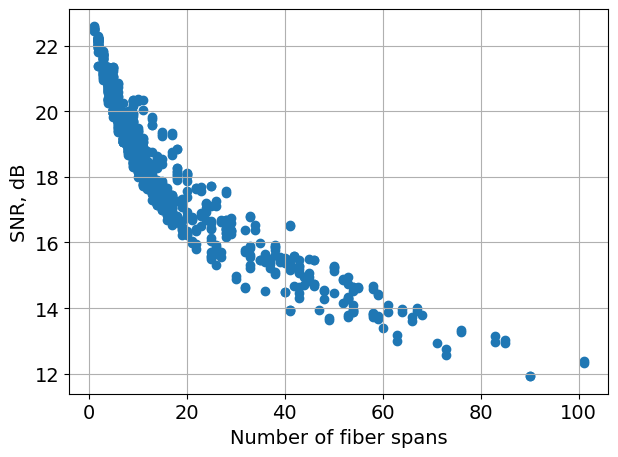

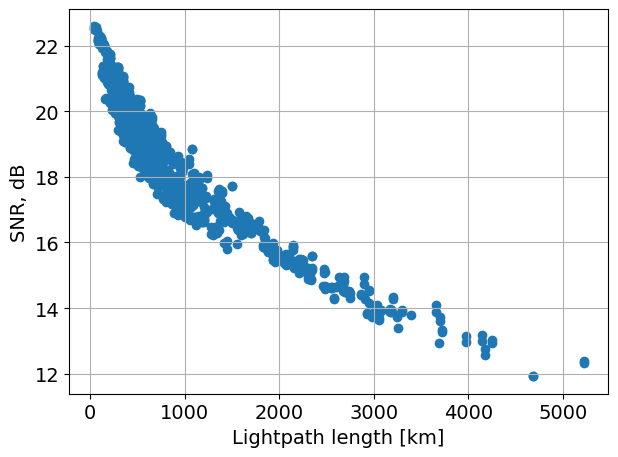

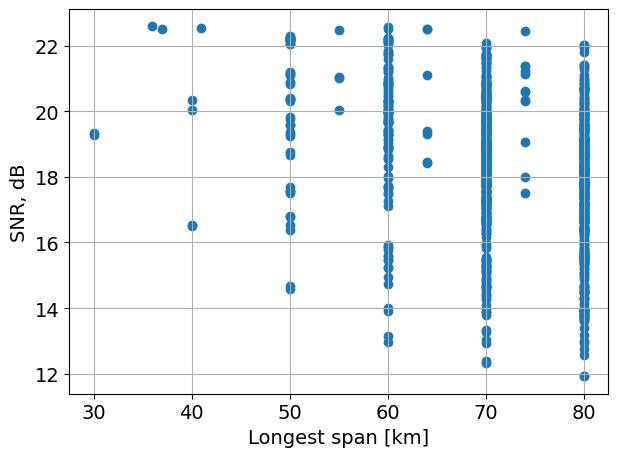

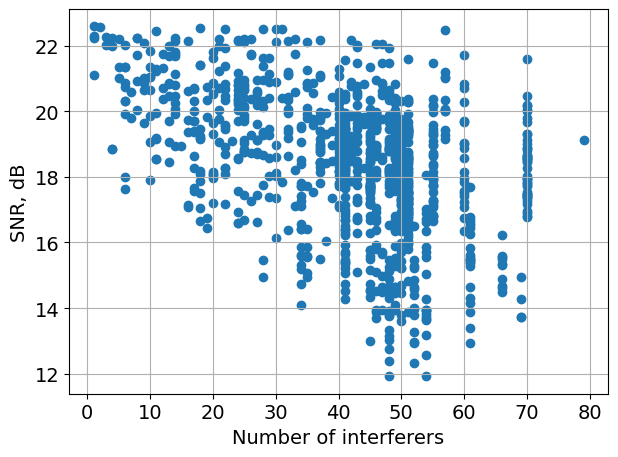

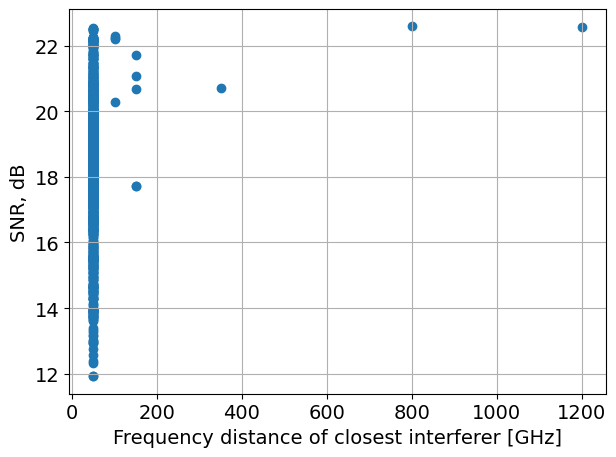

In [6]:
#F: figure settings to improve readability (customize as you prefer)

FONT_SIZE = 14
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)     # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

#F: if you want to save figures in a proper directory, uncomment the commented lines below
#res_folder = 'Results'
#if not os.path.exists(res_folder):
#    os.makedirs(res_folder)


plt.scatter(X[:, 0], snr_values)
plt.xlabel('Number of fiber spans')
plt.ylabel('SNR, dB')
plt.grid()
plt.tight_layout()
#plt.savefig(res_folder + '/SNR_vs_span_num.png')
plt.show()

plt.scatter(X[:, 1], snr_values)
plt.xlabel('Lightpath length [km]')
plt.ylabel('SNR, dB')
plt.grid()
plt.tight_layout()
#plt.savefig(res_folder + '/SNR_vs_lp_length.png')
plt.show()

#plt.bar(X[:, 2], snr_values, color='g')
plt.scatter(X[:, 2], snr_values)
plt.xlabel('Longest span [km]')
plt.ylabel('SNR, dB')
plt.grid()
plt.tight_layout()
#plt.savefig(res_folder + '/SNR_vs_longest_span.png')
plt.show()

plt.scatter(X[:, 3], snr_values)
plt.xlabel('Number of interferers')
plt.ylabel('SNR, dB')
plt.grid()
plt.tight_layout()
#plt.savefig(res_folder + '/SNR_vs_num_interf.png')
plt.show()

plt.scatter(X[:, 4], snr_values)
plt.xlabel('Frequency distance of closest interferer [GHz]')
plt.ylabel('SNR, dB')
plt.grid()
plt.tight_layout()
#plt.savefig(res_folder + '/SNR_vs_deltaf.png')
plt.show()


# Task 3a) 
Define function *train_NN()* that takes in input NN hyperparameters, performs training using a training set passed in input and provides training results (details below) 

Hints: 
- use *MLPRegressor* from *sklearn.neural_network*
- Documentation and background at:

     - https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
     
     - https://scikit-learn.org/stable/modules/neural_networks_supervised.html 

In [7]:
def train_NN(X_tr, y_tr, activ, neur, lyrs, solv_name = 'adam'):
# Inputs:    - X_tr: training set (features)
#            - y_tr: training set (output values)
#            - activ: activation function for the DNN hidden layers
#            - neur: number of neurons per layer (in the hidden layers) - each layer has the same no. of neurons
#            - lyrs: number of hidden layers 
#            - solv_name: solver to be used during training (default = 'adam')
# Output:    Return: 
#               1) fitted model, 
#               2) training duration
#
#            The function should also: 
#                a) Print the following statistics: 
#                     * number of training iterations
#                     * final loss
#                     * best loss during training
#                     * training duration 
#                     * training MSE
#                     * training R2 score
#                b) Plot learning curve (= loss vs epochs/iterations)
    print('Training a NN...')

    ############# ADD YOUR CODE BELOW #############
    
    size = (neur,) * lyrs #F: creates a tuple (due to the "(,)") with lyrs elements, all equal to neur
    model = MLPRegressor(hidden_layer_sizes = size, activation = activ, solver = solv_name, 
                         learning_rate = 'invscaling', max_iter = 5000, random_state = 42, verbose=False)
    t0 = time.time()
    model.fit(X_tr, y_tr)
    t1 = time.time()
    training_time = round(t1-t0,3)
    
    loss = model.loss_ #F: loss in MLPRegressor is the squared error
    print('Final loss: ' +str(loss))
    
    yhat = model.predict(X_tr)
    mse = mean_squared_error(y_tr, yhat) #F: note that this is different from loss (squared loss) by a factor 2 (roughly, MSE=2*loss)

    r2 = model.score(X_tr, y_tr)
    
    print('Total number of iterations: ' + str(model.n_iter_))
    print('Current loss: ' + str(round(model.loss_,3)))
    print('Best loss: ' + str(round(model.best_loss_,3)))
    #print('Loss values: ' + str(model.loss_curve_))
    print('Training time [s]: ' + str(training_time))
    print('Final training R2 score is: ' + str(round(r2,3)))
    print('Final training MSE is: ' + str(round(mse,3)))
    
    
    #plt.plot(model.loss_curve_)
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Training loss curve, solver: {}'.format(solv_name))
        
    #plt.tight_layout()

    ### F: in case you want to save in a results folder
    #res_folder = 'Results'
    #if not os.path.exists(res_folder):
    #    os.makedirs(res_folder)
    #plt.savefig(res_folder +'/Training_loss_curve_NN_{}-act_{}neur_{}lyrs_{}.png'.format(activ, neur, lyrs, solv_name))
        
    #plt.show()

    
    return model, training_time



# Task 3b) 

Scale features so as to have 0 mean and unit variance.

Split dataset (features matrix and output vector (SNR) retrieved in tasks 1b) and 2b)) into training and test sets (80/20%).

Call function *train_NN()* using scaled features matrix and output (SNR) **and with two different solvers ('sgd', 'adam')**.

Hints: 
- SNR vector is originally a list but must be converted into a numpy array (see below)
- use *StandardScaler* from *sklearn.preprocessing* to scale features https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- use *train_test_split* from *sklearn.model_selection* to split dataset into train/test sets https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- NN hyperparameters are given below
- use object name ***NNregr*** to host the model returned by function *train_NN()*


In [8]:
activation = 'logistic'
neurons = 10
layers = 2

solvers = ['sgd', 'adam']

y = np.array(snr_values) #F: y is the array of outputs (labels) in our dataset; np.array() is needed to work with arrays instead of lists

############# ADD YOUR CODE BELOW #############

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

for solver in solvers:
    print('Training with solver: ' + solver)
    NNregr, train_duration = train_NN(X_train, y_train, activation, neurons, layers, solver)

    ######## F: if you want to write results on a result file
    #res_folder = 'Results'
    #if not os.path.exists(res_folder):
    #os.makedirs(res_folder)
    
    #resfile = res_folder + '/Res_NN_{}-act_{}neur_{}lyrs_{}.txt'.format(activation, neurons, layers, solver)
    #with open(resfile, 'w') as result_file:
    #    result_file.write('Total number of iterations: {}\n'.format(NNregr.n_iter_))
    #    result_file.write('Current loss: {}\n'.format(round(NNregr.loss_,3)))
    #    result_file.write('Best loss: {}\n'.format(round(NNregr.best_loss_,3)))
    #    result_file.write('Training time [s]: {}\n'.format(train_duration))
        

Training with solver: sgd
Training a NN...


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Final loss: 5.179096527026568
Total number of iterations: 5000
Current loss: 5.179
Best loss: 5.179
Training time [s]: 12.366
Final training R2 score is: -1.322
Final training MSE is: 10.356
Training with solver: adam
Training a NN...
Final loss: 0.060687486572747654
Total number of iterations: 1696
Current loss: 0.061
Best loss: 0.061
Training time [s]: 4.238
Final training R2 score is: 0.973
Final training MSE is: 0.121


# Task 3c)

Define function *train_linreg()* that performs training using a training set passed in input and provides training results (details below) 

Hints: 
- use *LinearRegression* from *sklearn.linear_model* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- *N.B.* set "copy_X=True" (default) when instantiating linear regression model to avoid unwanted modification of the dataset



In [9]:
def train_linreg(X_tr, y_tr):
# Inputs:    - X_tr: training set (features)
#            - y_tr: training set (output values)
# Output:    Return: 1) fitted model, 2) training duration
#            The function should also print training duration and R2 score and MSE calculated on the training set

    print('Training a linear regressor model...')
    ############# ADD YOUR CODE BELOW #############
    
    model = LinearRegression()
    t0 = time.time()
    model.fit(X_tr, y_tr)
    t1 = time.time()
    training_time = round(t1-t0,3)

    yhat = model.predict(X_tr)
    r2 = model.score(X_tr, y_tr)
    mse = mean_squared_error(y_tr, yhat)

    print('Training time [s]: ' + str(training_time))
    print('Final training R2 score is: ' + str(round(r2,3)))
    print('Final training MSE is: ' + str(round(mse,3)))
    
    return model, training_time

# Task 3d)
Call function *train_linreg()* to fit a linear regressor using the same training set as for the NN 

(code is already given below)

In [10]:
linreg, train_duration_linreg = train_linreg(X_train, y_train)

Training a linear regressor model...
Training time [s]: 0.004
Final training R2 score is: 0.897
Final training MSE is: 0.459


# Task 3e)
Compare results (MSE and R2 score) for NN and Linear Regression in both train and test sets

(code is already given below)

In [11]:
#Training set
r2_linreg = linreg.score(X_train, y_train)
yhat_linreg = linreg.predict(X_train)
mse_linreg = mean_squared_error(y_train, yhat_linreg)

r2_NNregr = NNregr.score(X_train, y_train)
yhat_NNregr = NNregr.predict(X_train)
mse_NNregr = mean_squared_error(y_train, yhat_NNregr)

print('********** Training scores **********')
print('Linear Regression')
print('Final training R2 score is: ' + str(round(r2_linreg,3)))
print('Final training MSE is: ' + str(round(mse_linreg,3)))
print('\nNeural Network')
print('Final training R2 score is: ' + str(round(r2_NNregr,3)))
print('Final training MSE is: ' + str(round(mse_NNregr,3)))


#Test set
r2_linreg_test = linreg.score(X_test, y_test)
yhat_linreg_test = linreg.predict(X_test)
mse_linreg_test = mean_squared_error(y_test, yhat_linreg_test)

r2_NNregr_test = NNregr.score(X_test, y_test)
yhat_NNregr_test = NNregr.predict(X_test)
mse_NNregr_test = mean_squared_error(y_test, yhat_NNregr_test)

print('\n********** Test scores **********')
print('Linear Regression')
print('Final test R2 score is: ' + str(round(r2_linreg_test,3)))
print('Final test MSE is: ' + str(round(mse_linreg_test,3)))
print('\nNeural Network')
print('Final test R2 score is: ' + str(round(r2_NNregr_test,3)))
print('Final test MSE is: ' + str(round(mse_NNregr_test,3)))


********** Training scores **********
Linear Regression
Final training R2 score is: 0.897
Final training MSE is: 0.459

Neural Network
Final training R2 score is: 0.973
Final training MSE is: 0.121

********** Test scores **********
Linear Regression
Final test R2 score is: 0.901
Final test MSE is: 0.443

Neural Network
Final test R2 score is: 0.974
Final test MSE is: 0.114


## We had observed a high correlation between SNR and some of the features (e.g., lightpath length) 
## Do we need all the features?


# Task 4a)
Retrain NN and LR considering a new dataset that only includes **lightpath length** as a feature. 

Then, compare the performance of the two regressors on the same test set

**N.B. Use the SAME train/test sets used in task 3 (except the used features)**

Hints:
- *lightpath length* is the 2nd feature we included in the dataset (see task 2a)
- use same hyperparameters as above for the NN architecture

In [12]:
#F: you need to reshape inputs before passing to train_NN() as function fit() works only with 2D arrays
X_train_new = X_train[:,1].reshape(-1, 1)
X_test_new = X_test[:,1].reshape(-1, 1)
#X_train_new.shape #--->(827, 1)
#X_test_new.shape #--->(207, 1)
############# ADD YOUR CODE BELOW #############

NNregr_new, _ = train_NN(X_train_new, y_train, activation, neurons, layers)

linreg_new, _ = train_linreg(X_train_new, y_train)


#Test set
r2_linreg_test_new = linreg_new.score(X_test_new, y_test)
yhat_linreg_test_new = linreg_new.predict(X_test_new)
mse_linreg_test_new = mean_squared_error(y_test, yhat_linreg_test_new)

r2_NNregr_test_new = NNregr_new.score(X_test_new, y_test)
yhat_NNregr_test_new = NNregr_new.predict(X_test_new)
mse_NNregr_test_new = mean_squared_error(y_test, yhat_NNregr_test_new)

print('********** Test scores **********')
print('Linear Regression')
print('Final test R2 score is: ' + str(round(r2_linreg_test_new,3)))
print('Final test MSE is: ' + str(round(mse_linreg_test_new,3)))
print('\nNeural Network')
print('Final test R2 score is: ' + str(round(r2_NNregr_test_new,3)))
print('Final test MSE is: ' + str(round(mse_NNregr_test_new,3)))



Training a NN...
Final loss: 0.11577911515448566
Total number of iterations: 1819
Current loss: 0.116
Best loss: 0.116
Training time [s]: 4.33
Final training R2 score is: 0.948
Final training MSE is: 0.232
Training a linear regressor model...
Training time [s]: 0.002
Final training R2 score is: 0.841
Final training MSE is: 0.709
********** Test scores **********
Linear Regression
Final test R2 score is: 0.863
Final test MSE is: 0.61

Neural Network
Final test R2 score is: 0.949
Final test MSE is: 0.229


# Task 4b)
Plot in the same graph the data points of test set and the curves produced by the univariate NN and LR for a range of lightpath length values as in the test set

(code is already given below)

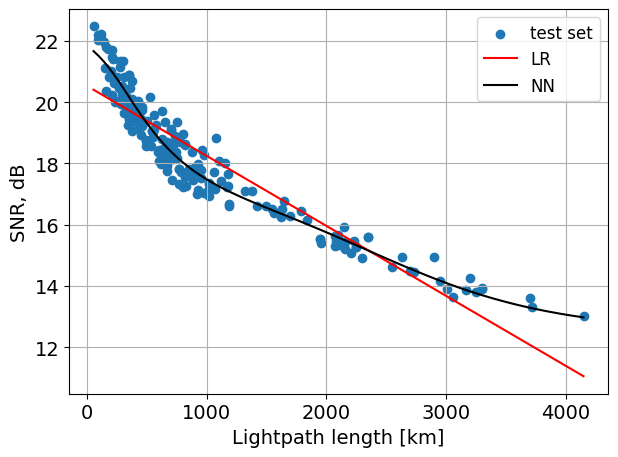

In [13]:
#F: generate "fake" random lightpath lengths
#F: note that they should be in the range of normalized feature values 
#F: and then we need to rescale to realistic values applying the inverse transform

minlength = min(X_test_new)
maxlength = max(X_test_new)
xx = np.linspace(minlength,maxlength,num=100)

#F: calculate the predictions with the two ML algorithms for the "fake" inputs
yyLR = linreg_new.predict(xx)
yyNN = NNregr_new.predict(xx)

#F: rescale fake inputs
m = scaler.mean_[1] #F: item no. 1 because lightpath length is the second feature of the original dataset
s = scaler.scale_[1] #F: item no. 1 because lightpath length is the second feature of the original dataset
xvalues = xx*s + m

#F: rescale real inputs
Xtr = scaler.inverse_transform(X_test, copy=None)

#F: plot
plt.scatter(Xtr[:, 1], y_test, label='test set')
plt.plot(xvalues,yyLR,color="red", label='LR')
plt.plot(xvalues,yyNN,color="black", label='NN')
plt.xlabel('Lightpath length [km]')
plt.ylabel('SNR, dB')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



# Task 5a) 
Define function *SNR_to_MF()* that takes in input SNR value and uses it to return the highest possible modulation format (MF) 

Hint: 
- refer to table with SNR-MF mapping in the slides

(code is already given below)

In [14]:
def SNR_to_MF(SNR):
# Input:    - SNR: SNR value (predicted or ground truth) used to decide modulation format
# Output:   - order of the highest configurable MF; return a number corresponding to the MF 
#             4 (QPSK), 8 (8QAM), 16 (16QAM), 32 (32QAM), 64 (64QAM)

# < and > instead of <= and >=, as SNR is a float and floats cannot be compared with equality
    if SNR < 11:
        return 0
    
    elif SNR > 11 and SNR < 15:
        return 4
    
    elif SNR > 15 and SNR < 18:
        return 8
    
    elif SNR > 18 and SNR < 20.8:
        return 16
    
    elif SNR > 20.8 and SNR < 23.7:
        return 32
    
    else:
        return 64

# Task 5b) 
Define function *find_minimal_margin()* that takes in input predicted and ground truth SNR vectors and find the minimum margin to subtract to prediction in order not to have any disruption due to a higher-order MF in prediction wrt ground truth

Hint:
- start with margin=0 and iteratively increase it until you find no difference in MF between predicted and ground truth values

In [15]:
def find_minimal_margin(SNR_true_vect, SNR_pred_vect):
# Input:    - SNR_true_vect: ground truth SNR values 
#           - SNR_pred_vect: predicted SNR values
# Output:   - minimal margin M (dB) that should be subtracted from the predicted SNR,
#             so that MF configured based on (predicted SNR - Margin) will not exceed  
#             the one set based on the true SNR to avoid disruptions
############# ADD YOUR CODE BELOW #############
    
    margin = 0 #dB
    margin_step = 0.1 #dB

    # make 100 attempts, increasing margin by 0.1 dB at a time
    # maximum considered margin: 0.1 * 100 = 10 dB 
    for i in range(100):
        
        disruption_flag = False 
        #F: for the current margin, this flag will become "True" if the margin is not sufficient to avoid disruption
        
        
        for SNR_true, SNR_pred in zip(SNR_true_vect, SNR_pred_vect):

            MF_true = SNR_to_MF(SNR_true)
            MF_pred = SNR_to_MF(SNR_pred - margin)

            if MF_pred > MF_true:
                disruption_flag = True 
                break
                
        if disruption_flag == False: #F: we quit the function (and return the min margin) when there is no disruption (disruption_flag == False) for all pairs of SNR_true, SNR_pred
            return margin
            
        else:
            margin += margin_step
            
    return margin


# Task 5c) 
Test function *find_minimal_margin()* to check if the returned margin allows no disruption for all elements in a predicted SNR vector (compared to its ground truth). Repeat the check comparing ground truth vs non-margined prediction 

Hints: 
- use the (multivariate) NN already used in task 3e)
- you can verify that there is no disruption checking if the MF for SNR = (pred_SNR - margin) is < than the MF for SNR = groundtruth_SNR 

(code is already given below)

In [16]:
y_predicted = NNregr.predict(X_test)

min_margin = find_minimal_margin(y_test, y_predicted)
print('Minimum margin: {} dB'.format(min_margin))

y_margined = y_predicted - min_margin

print('***** NON MARGINED PREDICTED SNR *****')
num_diff_MF = 0
num_overrated_MF = 0
num_underrated_MF = 0

for i in range(len(y_test)):
    if SNR_to_MF(y_predicted[i]) != SNR_to_MF(y_test[i]):
        #print('I found a different MF: {} vs {} (pred vs ground truth)'.format(SNR_to_MF(y_predicted[i]), SNR_to_MF(y_test[i])))
        num_diff_MF += 1
        if SNR_to_MF(y_predicted[i]) > SNR_to_MF(y_test[i]):
            num_overrated_MF +=1
        else:
            num_underrated_MF +=1
            
print('Number of incorrectly-assigned MFs: ' + str(num_diff_MF))
print('Number of overrated MFs: ' + str(num_overrated_MF))
print('Number of underrated MFs: ' + str(num_underrated_MF))


print('******* MARGINED PREDICTED SNR *******')
num_diff_MF = 0
num_overrated_MF = 0
num_underrated_MF = 0

for i in range(len(y_test)):
    if SNR_to_MF(y_margined[i]) != SNR_to_MF(y_test[i]):
        #print('I found a different MF: {} vs {} (pred_margined vs ground truth)'.format(SNR_to_MF(y_margined[i]), SNR_to_MF(y_test[i])))
        num_diff_MF += 1
        if SNR_to_MF(y_margined[i]) > SNR_to_MF(y_test[i]):
            num_overrated_MF +=1
        else:
            num_underrated_MF +=1

print('Number of incorrectly-assigned MFs: ' + str(num_diff_MF))
print('Number of overrated MFs: ' + str(num_overrated_MF))
print('Number of underrated MFs: ' + str(num_underrated_MF))



Minimum margin: 1.0999999999999999 dB
***** NON MARGINED PREDICTED SNR *****
Number of incorrectly-assigned MFs: 16
Number of overrated MFs: 9
Number of underrated MFs: 7
******* MARGINED PREDICTED SNR *******
Number of incorrectly-assigned MFs: 86
Number of overrated MFs: 0
Number of underrated MFs: 86


# Task 6a)
Define function *perf_eval()* that takes in input real and predicted SNR vectors and provides results (details below) 

Hints: 
- use *max_error* and *mean_squared_error* from *sklearn.metrics*
- use *round(..., 1)* to obtain an error vector with 0.1 granularity

In [17]:
def perf_eval(y_true, y_pred):
# Inputs:    - y_true: test set ground truth SNR values 
#            - y_pred: predicted SNR values
# This function should: 1) print mean squared error (MSE) and maximum error of SNR
#                       2) calculate and print the minimum SNR margin required to avoid disruptions
#                       3) calculate and plot (as bar graph) the distribution of errors (use 0.1 error bins)
#                       4) print the distribution of errors in output in the 
#                          following form: 'errorvalue [dB]: n times' (e.g., '0.5 [dB]: 3 times')
    
    error_dict = {} #F: this dictionary will host the distribution of errors, 
                    #   e.g., {-0.3: 9,..., 0.5: 3, ...}, means that 
                    #   error -0.3 dB is done 9 times, error 0.5 3 times etc.
    
    ############# ADD YOUR CODE BELOW #############
    
    print('MSE: {} dB\n'.format(round(mean_squared_error(y_true, y_pred), 2)))
    print('Max error: {} dB\n'.format(round(max_error(y_true, y_pred), 2)))
        
    min_margin_dB = round(find_minimal_margin(y_true, y_pred), 2)
    print('Minimal margin to avoid disruptions {} dB\n'.format(min_margin_dB))

    for SNR_dB_true, SNR_dB_pred in zip(y_true, y_pred):        
        #F: 0.1 error bins, i.e., error with a single digit after point
        err = round(SNR_dB_true - SNR_dB_pred, 1)

        if err in error_dict:
            error_dict[err] += 1

        else:
            error_dict[err] = 1
        
    print(error_dict)

    print('Error histogram\n')
    error_list = sorted(error_dict.items(), key=lambda x: x[0])
        
    for k, v in error_list:
        print('{} dB: {} times'.format(k, v))
    
    
    #################################################################
    plt.bar(list(error_dict.keys()), error_dict.values(), color='g', width = 0.07)
    plt.xlabel('Error value, dB')
    plt.ylabel('Samples')
    plt.title('SNR estimation error distribution')
    plt.tight_layout()
    plt.show()
        

# Task 6b) 
Use the NN model already used in task 3e) to perform prediction for test set and call function *perf_eval()* to evaluate performance

(code is already given below)


MSE: 0.11 dB

Max error: 1.14 dB

Minimal margin to avoid disruptions 0.4 dB

{-0.3: 9, -0.1: 26, -0.5: 8, 0.1: 26, -0.0: 27, 0.8: 1, -0.2: 25, -0.4: 10, -0.9: 1, 0.2: 15, 0.3: 17, 0.4: 13, 0.5: 11, 1.1: 2, 0.7: 3, -0.6: 7, 0.6: 5, -1.1: 1}
Error histogram

-1.1 dB: 1 times
-0.9 dB: 1 times
-0.6 dB: 7 times
-0.5 dB: 8 times
-0.4 dB: 10 times
-0.3 dB: 9 times
-0.2 dB: 25 times
-0.1 dB: 26 times
-0.0 dB: 27 times
0.1 dB: 26 times
0.2 dB: 15 times
0.3 dB: 17 times
0.4 dB: 13 times
0.5 dB: 11 times
0.6 dB: 5 times
0.7 dB: 3 times
0.8 dB: 1 times
1.1 dB: 2 times


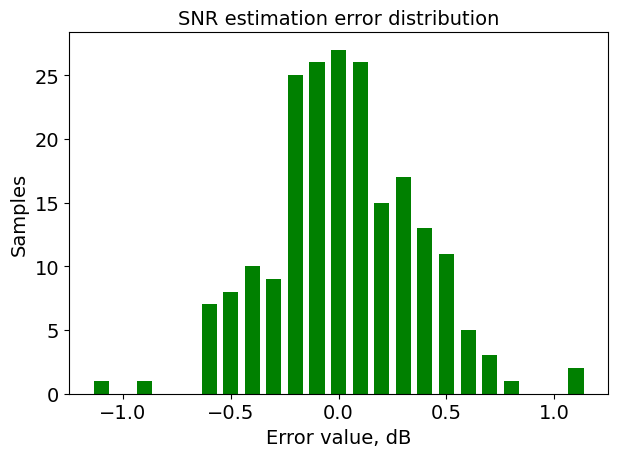

In [18]:
y_predicted = NNregr.predict(X_test)

perf_eval(y_predicted,y_test)


# Tasks 7a)-7b) - HOMEWORK (max 1.5 points)

# Task 7a) 
Define function *extract_UNCERTAIN_features()* (take inspiration from function *extract_features()* in task 2a), that generates span length features **with a random error chosen in a normal distribution with 0 mean and std dev *sigma* passed in input**

Hint: 
- use *random.gauss* from *random* to generate the error 

In [19]:
def extract_UNCERTAIN_features(span_matrix, interferer_matrix, span_length_std = 0):
# Inputs:    - span_matrix: matrix (list) of spans for each lightpath as returned by function read_dataset()
#            - interferer_matrix: matrix (list) of interferers info (number of interferers and Delta-f) as returned by function read_dataset()
#            - span_length_std: std dev of the normal distribution used to generate error in the span length
# Output:    - numpy array X_matrix  with the following features (one row for each lightpath):
#                1) Number of fiber spans along the path
#                2) Total lightpath length
#                3) Longest fiber span length (between 2 amplifiers)
#                4) Maximum number of interferers across all the links traversed
#                5) Frequency distance from the closest interferer across all the links traversed
    X_matrix = [] #F: name of the numpy array to return
############# ADD YOUR CODE BELOW #############
    
    
    for span_len_vect, interferer_vect in zip(span_matrix, interferer_matrix):
                
            
        feature_vect = []
        
        span_len_vect_noisy = [span + random.gauss(0, span_length_std) for span in span_len_vect]  
        
        feature_vect.append(len(span_len_vect_noisy))
        feature_vect.append(sum(span_len_vect_noisy))
        feature_vect.append(max(span_len_vect_noisy))
        
        feature_vect.append(interferer_vect[0])
        feature_vect.append(interferer_vect[1])
        
        X_matrix.append(feature_vect)

    return np.array(X_matrix)

# Task 7b) 
Consider NN algortihm only and redo training and performance evaluation using a new dataset with uncertain features, where error in span length is introduced with std dev = to 5%, 10%, 15% of the maximum span length across all lightpaths.

Specifically, after reading the dataset (task 1b), for each error std dev, the steps are:
- generate features matrix (new function from task 7a)
- scale, split the dataset and train a new NN (task 3b)
- predict and evaluate performance (task 6b)

Hint: 
- we had calculated a vector with all max span length in task 2b). This can be used to retrieve the maximum span length across all lightpaths

Max span:  80 [km]
Current std:  4.0 [km]
Training a NN...
Final loss: 0.060322232490749916
Total number of iterations: 1799
Current loss: 0.06
Best loss: 0.06
Training time [s]: 8.229
Final training R2 score is: 0.973
Final training MSE is: 0.12
MSE: 0.11 dB

Max error: 1.28 dB

Minimal margin to avoid disruptions 1.0 dB

{-0.2: 20, -0.3: 13, -0.4: 9, 0.2: 17, -0.0: 25, 0.7: 2, -0.1: 32, -0.9: 1, 0.5: 10, 0.1: 20, 0.4: 16, 0.3: 20, 1.3: 1, 0.8: 1, -0.6: 3, 0.6: 3, -0.5: 11, 1.0: 1, -1.1: 1, 1.1: 1}
Error histogram

-1.1 dB: 1 times
-0.9 dB: 1 times
-0.6 dB: 3 times
-0.5 dB: 11 times
-0.4 dB: 9 times
-0.3 dB: 13 times
-0.2 dB: 20 times
-0.1 dB: 32 times
-0.0 dB: 25 times
0.1 dB: 20 times
0.2 dB: 17 times
0.3 dB: 20 times
0.4 dB: 16 times
0.5 dB: 10 times
0.6 dB: 3 times
0.7 dB: 2 times
0.8 dB: 1 times
1.0 dB: 1 times
1.1 dB: 1 times
1.3 dB: 1 times


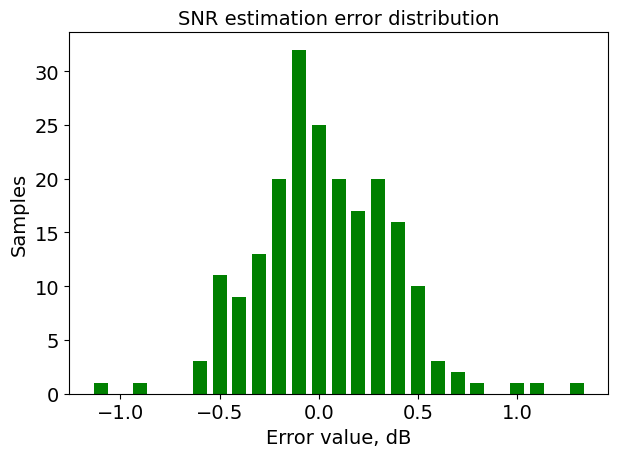

Current std:  8.0 [km]
Training a NN...
Final loss: 0.06773203110411447
Total number of iterations: 1718
Current loss: 0.068
Best loss: 0.068
Training time [s]: 7.344
Final training R2 score is: 0.97
Final training MSE is: 0.135
MSE: 0.14 dB

Max error: 1.28 dB

Minimal margin to avoid disruptions 1.0 dB

{-0.4: 14, -0.3: 13, -0.6: 5, 0.1: 20, 0.0: 22, 0.3: 14, 0.9: 3, -0.2: 19, -0.1: 25, -1.1: 1, 0.2: 22, 0.6: 3, 0.4: 20, 0.5: 10, 1.3: 1, 0.7: 2, -0.8: 1, -0.5: 7, -1.2: 1, -0.7: 2, -0.9: 1, 1.0: 1}
Error histogram

-1.2 dB: 1 times
-1.1 dB: 1 times
-0.9 dB: 1 times
-0.8 dB: 1 times
-0.7 dB: 2 times
-0.6 dB: 5 times
-0.5 dB: 7 times
-0.4 dB: 14 times
-0.3 dB: 13 times
-0.2 dB: 19 times
-0.1 dB: 25 times
0.0 dB: 22 times
0.1 dB: 20 times
0.2 dB: 22 times
0.3 dB: 14 times
0.4 dB: 20 times
0.5 dB: 10 times
0.6 dB: 3 times
0.7 dB: 2 times
0.9 dB: 3 times
1.0 dB: 1 times
1.3 dB: 1 times


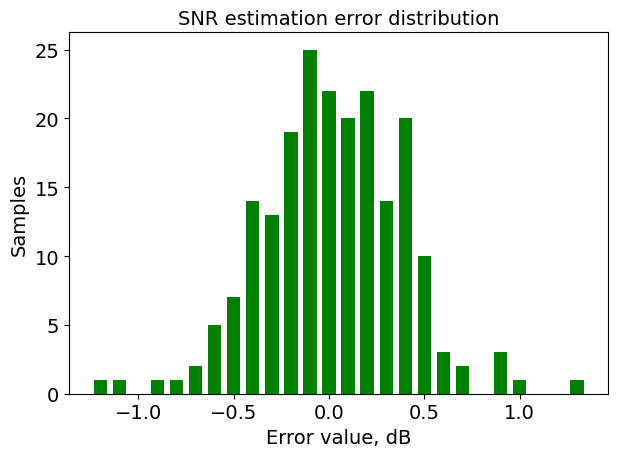

Current std:  12.0 [km]
Training a NN...
Final loss: 0.076432619887536
Total number of iterations: 1744
Current loss: 0.076
Best loss: 0.076
Training time [s]: 8.057
Final training R2 score is: 0.966
Final training MSE is: 0.153
MSE: 0.14 dB

Max error: 1.43 dB

Minimal margin to avoid disruptions 1.0 dB

{-0.5: 8, -0.4: 14, -0.6: 8, -0.1: 22, 0.1: 25, 0.7: 3, -0.3: 13, -1.1: 2, 0.2: 18, 0.0: 20, -0.2: 20, 0.3: 14, 0.4: 16, 0.5: 10, 1.4: 1, 0.6: 4, 0.8: 3, -0.8: 1, -0.9: 1, -0.7: 4}
Error histogram

-1.1 dB: 2 times
-0.9 dB: 1 times
-0.8 dB: 1 times
-0.7 dB: 4 times
-0.6 dB: 8 times
-0.5 dB: 8 times
-0.4 dB: 14 times
-0.3 dB: 13 times
-0.2 dB: 20 times
-0.1 dB: 22 times
0.0 dB: 20 times
0.1 dB: 25 times
0.2 dB: 18 times
0.3 dB: 14 times
0.4 dB: 16 times
0.5 dB: 10 times
0.6 dB: 4 times
0.7 dB: 3 times
0.8 dB: 3 times
1.4 dB: 1 times


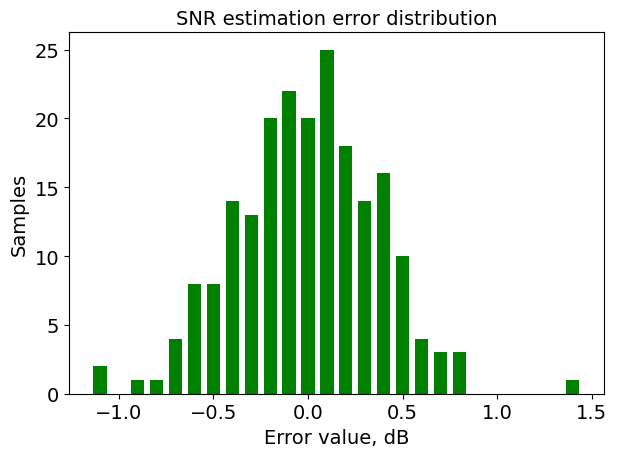

In [31]:
new_datafile = 'SNR_dataset_0.25dB_per_km.txt'

#F: Task 1b)
new_spans, new_interferers, new_snr_values = read_dataset(new_datafile)

new_y = np.array(snr_values)
############# ADD YOUR CODE BELOW #############

max_span = max([max(span_len_vect) for span_len_vect in new_spans]) 
print('Max span: ', max_span, '[km]')
std_vect = [0.05*max_span, 0.1*max_span, 0.15*max_span]

for std in std_vect:
    print('Current std: ', std, '[km]')
    #1)
    new_X = extract_UNCERTAIN_features(new_spans, new_interferers, std)
    
    #2)
    scaler = StandardScaler()
    new_X = scaler.fit_transform(new_X)
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_X, new_y, test_size=0.2, shuffle=True, random_state = 42)
    NNregr_new, _ = train_NN(X_train_new, y_train_new, activation, neurons, layers)
    
    #3)
    y_predicted_new = NNregr_new.predict(X_test_new)
    perf_eval(y_predicted_new,y_test_new)
    
# max error and final training MSE get largeras the std increases. The spread of error also increases
# wrt std.